### Network Model of the NYC Subway Network with IBX Stations

In [1]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
#make sure plots are embedded into the notebook
%matplotlib inline 
#pd.set_option('max_columns',None)

In [2]:
#station list, with IBX stations encoded
Stations = pd.read_csv('Stations_wIBX.csv', index_col=0, header=0)
Stations

,name,id,boro,lat,long,lines
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G
1,21 St,G24,Q,40.744065,-73.949724,G
2,Court Sq,G22,Q,40.746554,-73.943832,G
3,36 St,G20,Q,40.752039,-73.928781,M R
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R
...,...,...,...,...,...,...
502,Rockaway Pkwy,X8,Bk,40.651228,-73.908889,IBX
503,Myrtle Av,X12,Q,40.700453,-73.894421,IBX
504,74 St,X14,Q,40.733015,-73.887789,IBX
505,Queens Blvd,X15,Q,40.738486,-73.890111,IBX


In [ ]:
#filter out Staten Island, as its rail network is unconnected with the rest of the network
#Stations = Stations.loc[Stations['boro'] != 'SI']

In [3]:
#Split the lines into multiple columns
Stations = Stations.join(Stations['lines'].str.split(' ', expand=True)).rename({0:'line_1',1:'line_2',2:'line_3',3:'line_4'}, axis=1)
Stations

,name,id,boro,lat,long,lines,line_1,line_2,line_3,line_4
0,Greenpoint Av,G26,Bk,40.731352,-73.954449,G,G,None,None,None
1,21 St,G24,Q,40.744065,-73.949724,G,G,None,None,None
2,Court Sq,G22,Q,40.746554,-73.943832,G,G,None,None,None
3,36 St,G20,Q,40.752039,-73.928781,M R,M,R,None,None
4,Queens Plaza,G21,Q,40.748973,-73.937243,E M R,E,M,R,None
...,...,...,...,...,...,...,...,...,...,...
502,Rockaway Pkwy,X8,Bk,40.651228,-73.908889,IBX,IBX,None,None,None
503,Myrtle Av,X12,Q,40.700453,-73.894421,IBX,IBX,None,None,None
504,74 St,X14,Q,40.733015,-73.887789,IBX,IBX,None,None,None
505,Queens Blvd,X15,Q,40.738486,-73.890111,IBX,IBX,None,None,None


In [4]:
#For stations with more than 1 line, unpivot to create new rows.
stli = pd.wide_to_long(Stations, stubnames='line_',i='id',j='station_line').sort_index(level=0)
stli.dropna(inplace=True)
stli.reset_index(inplace=True)
stli.rename({'id':'station_id'},axis=1,inplace=True)
stli

,station_id,station_line,name,boro,lines,lat,long,line_
0,101,1,Van Cortlandt Park - 242 St,Bx,1,40.889248,-73.898583,1
1,103,1,238 St,Bx,1,40.884667,-73.900870,1
2,104,1,231 St,Bx,1,40.878856,-73.904834,1
3,106,1,Marble Hill - 225 St,M,1,40.874561,-73.909831,1
4,107,1,215 St,M,1,40.869444,-73.915279,1
...,...,...,...,...,...,...,...,...
783,X16,1,Jackson Hts,Q,IBX,40.746530,-73.894401,IBX
784,X5,1,Brooklyn College,Bk,IBX,40.630902,-73.947985,IBX
785,X6,1,Farragut Rd - Utica Av,Bk,IBX,40.637348,-73.928442,IBX
786,X7,1,Ralph Av,Bk,IBX,40.643589,-73.919353,IBX


In [5]:
#each station-line has 2 platforms for trains going in both directions, so we can duplicate the table
pfs = pd.concat([stli]*2)
#create a new columns to distinguish north and south-bound trains, add South designation to half of the rows
pfs['dir'] = 'N'
pfs.iloc[:stli.shape[0],8] = 'S'
pfs

,station_id,station_line,name,boro,lines,lat,long,line_,dir
0,101,1,Van Cortlandt Park - 242 St,Bx,1,40.889248,-73.898583,1,S
1,103,1,238 St,Bx,1,40.884667,-73.900870,1,S
2,104,1,231 St,Bx,1,40.878856,-73.904834,1,S
3,106,1,Marble Hill - 225 St,M,1,40.874561,-73.909831,1,S
4,107,1,215 St,M,1,40.869444,-73.915279,1,S
...,...,...,...,...,...,...,...,...,...
783,X16,1,Jackson Hts,Q,IBX,40.746530,-73.894401,IBX,N
784,X5,1,Brooklyn College,Bk,IBX,40.630902,-73.947985,IBX,N
785,X6,1,Farragut Rd - Utica Av,Bk,IBX,40.637348,-73.928442,IBX,N
786,X7,1,Ralph Av,Bk,IBX,40.643589,-73.919353,IBX,N


In [6]:
#create platform_id field based on station_id + line + dir
pfs['pf_id'] = pfs['station_id'] + '-' + pfs['line_'] + '-' + pfs['dir']
pfs

,station_id,station_line,name,boro,lines,lat,long,line_,dir,pf_id
0,101,1,Van Cortlandt Park - 242 St,Bx,1,40.889248,-73.898583,1,S,101-1-S
1,103,1,238 St,Bx,1,40.884667,-73.900870,1,S,103-1-S
2,104,1,231 St,Bx,1,40.878856,-73.904834,1,S,104-1-S
3,106,1,Marble Hill - 225 St,M,1,40.874561,-73.909831,1,S,106-1-S
4,107,1,215 St,M,1,40.869444,-73.915279,1,S,107-1-S
...,...,...,...,...,...,...,...,...,...,...
783,X16,1,Jackson Hts,Q,IBX,40.746530,-73.894401,IBX,N,X16-IBX-N
784,X5,1,Brooklyn College,Bk,IBX,40.630902,-73.947985,IBX,N,X5-IBX-N
785,X6,1,Farragut Rd - Utica Av,Bk,IBX,40.637348,-73.928442,IBX,N,X6-IBX-N
786,X7,1,Ralph Av,Bk,IBX,40.643589,-73.919353,IBX,N,X7-IBX-N


In [7]:
#let's change the lat-long slightly for the platforms so they aren't totally on top of each other. this is not meant to be geographically accurate!
#offset the 1st platform from the station by .0006 degrees lat, which is about 200 feet north
pfs.loc[pfs.station_line ==1,'lat'] = pfs.loc[pfs.station_line ==1,'lat'] + .0006
pfs.loc[pfs.station_line ==2,'long'] = pfs.loc[pfs.station_line ==2,'long'] + .0006 #offset to east
pfs.loc[pfs.station_line ==3,'lat'] = pfs.loc[pfs.station_line ==3,'lat'] - .0006  #offset to south
pfs.loc[pfs.station_line ==4,'long'] = pfs.loc[pfs.station_line ==4,'long'] - .0006 #offset to west

#and let's offset the north platforms from the south by adding .0001 degrees lat or ~35 feet north
pfs.loc[pfs.dir =='N','lat'] = pfs.loc[pfs.dir =='N','lat'] + .0006


In [8]:
#finally, let's concatenate the stations to the platforms
Stations.rename({'id':'station_id','lines':'line_'},axis=1,inplace=True)
Stations.drop(['line_1','line_2','line_3','line_4'],axis = 1,inplace=True)
Stations[['pf_id','dir','station_line']] = 'station'
nodes = pd.concat([pfs,Stations])

In [9]:
nodes['node_id'] = np.where(nodes['pf_id'] != 'station',nodes['pf_id'],nodes['station_id'])
nodes.reset_index(inplace=True,drop=True)
nodes

,station_id,station_line,name,boro,lines,lat,long,line_,dir,pf_id,node_id
0,101,1,Van Cortlandt Park - 242 St,Bx,1,40.889848,-73.898583,1,S,101-1-S,101-1-S
1,103,1,238 St,Bx,1,40.885267,-73.900870,1,S,103-1-S,103-1-S
2,104,1,231 St,Bx,1,40.879456,-73.904834,1,S,104-1-S,104-1-S
3,106,1,Marble Hill - 225 St,M,1,40.875161,-73.909831,1,S,106-1-S,106-1-S
4,107,1,215 St,M,1,40.870044,-73.915279,1,S,107-1-S,107-1-S
...,...,...,...,...,...,...,...,...,...,...,...
2078,X8,station,Rockaway Pkwy,Bk,NaN,40.651228,-73.908889,IBX,station,station,X8
2079,X12,station,Myrtle Av,Q,NaN,40.700453,-73.894421,IBX,station,station,X12
2080,X14,station,74 St,Q,NaN,40.733015,-73.887789,IBX,station,station,X14
2081,X15,station,Queens Blvd,Q,NaN,40.738486,-73.890111,IBX,station,station,X15


In [ ]:
nodes.iloc[100:140]

In [ ]:
#next step is edges. the edge list actually shows multiple edges for each line and direction. for example, station 230 (Wall Street) 
# and station 231 (Clark Street) are already connected by 4 edges: the 2 and 3 trains, northbound and southbound. However, because the stations
# are represented as single nodes, these 4 edges are indistinguishable from one another, and networkx only uses 1 of them anyway.

#so for each of these existing edges, we need to reset the origin and destination based on the platform_id. In the example above, we need to
# end up with the following edges:
# 230-2-S --> 231-2-S
# 230-3-S --> 231-3-S
# 231-2-N --> 230-2-N
# 231-3-N --> 230-3-N

#actually, we don't need this to be a directed graph, so don't worry if northbound edges are going south.
# But it is important that only edges with the same line and direction are connected. So we can't have a southbound train going to a northbound
# platform, and we can't have a 2 train going to a 3 platform (even though in actuality they do share a platfom)

#So basically, for each unique origin and destination in the edge list, we need to look up the lines that are serving both of those stations.
# If the stations have line(s) in common, we draw an edge between the corresponding platforms in both directions

# I think the easiest way to do this in practice is to add a bunch of columns to the edge list, for each of the ~31 subway lines
# If both the origin and destination of the edge contain the same line, mark that as a 1, otherwise if one/both doesn't have that line mark 0

#After all of this, don't forget to add edges between the stations and platforms!


In [10]:
#connection list, with IBX connections encoded
Links = pd.read_csv('Links_wIBX.csv', index_col=0, header=0)
Links.head()

,origin,dest
0,G26,G24
1,G26,G28
2,G24,G26
3,G24,G22
4,G22,G24


In [11]:
#the repeated edges are of no use to us, so let's get unique edges.
uLinks = Links.drop_duplicates().reset_index()
uLinks.drop('index',axis=1,inplace=True)
uLinks.shape

(1246, 2)

In [ ]:
#get the links for the Prospect Park Shuttle
# S_links = uLinks.loc[(uLinks['origin'].isin(['S01', 'S03', 'S04'])) | \
# (uLinks['dest'].isin(['S01', 'S03', 'S04']))]

# S_links

In [ ]:
#drop links from Staten Island, concatenate Shuttle links back in (since they get dropped here)
# uLinks = uLinks.loc[(~uLinks['origin'].str.startswith('S')) | (~uLinks['dest'].str.startswith('S'))]

# uLinks = pd.concat([uLinks, S_links], ignore_index=True)
# uLinks

In [12]:
#Also, we don't need a directed graph because we will incorporate that logic into the platforms, i.e. only northbound platforms can have an edge, but the direction of that edge
#isn't important. If the northbound edges are actually going south geographically, it doesn't make a difference. So let's remove duplicate edges that are A-->B and B-->A
uuLinks = uLinks[~pd.DataFrame(np.sort(uLinks[['origin','dest']].values,1)).duplicated()].sort_values('origin')
uuLinks.reset_index(inplace=True)
uuLinks

,index,origin,dest
0,126,103,104
1,125,103,101
2,129,106,104
3,128,106,107
4,122,108,107
...,...,...,...
638,1226,X16,G14
639,1214,X5,X6
640,1215,X6,X7
641,1216,X7,X8


In [13]:
d = pd.DataFrame(np.zeros((uuLinks.shape[0], pfs.line_.nunique())))
d.columns = pfs.line_.unique()
uuLinks = pd.concat([uuLinks,d],axis=1)
uuLinks

,index,origin,dest,1,2,3,5,4,6,7,...,Q,M,IBX,N,J,Z,R,L,W,SIR
0,126,103,104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,125,103,101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,129,106,104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,128,106,107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,122,108,107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,1226,X16,G14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,1214,X5,X6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
640,1215,X6,X7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641,1216,X7,X8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
i = 0
for o, d in zip(uuLinks.origin, uuLinks.dest):
    o_lines = Stations.loc[Stations['station_id'] == o,'line_'].str.strip().str.split(' ').values[0]
    d_lines = Stations.loc[Stations['station_id'] == d,'line_'].str.strip().str.split(' ').values[0]
    common = [value for value in o_lines if value in d_lines]
    for lc in common:
        uuLinks.loc[uuLinks.index[i],lc] =1
    i +=1

In [15]:
#I got the output I wanted, but it's tricky because some stations are actually represented as multiple nodes, e.g. Union Sq vs Union Sq - 14 St.
# There are actually quite a few of these (146 edges). I will draw edges between the stations themselves, not the platforms. So basically I can leave them as-is.
# everything else is a platform-platform edge (until we draw station-platform edges)

uuLinks['total_edges'] = 0
for i in uuLinks.index:
    uuLinks.loc[i, 'total_edges'] = uuLinks.loc[i, '1':'total_edges'].sum()

pfs_edges = uuLinks[uuLinks['total_edges'] > 0]
ss_edges = uuLinks[uuLinks['total_edges'] == 0]


In [ ]:
pfs_edges.head()

In [16]:
#each platform edge needs to be multiplied by the total_edges. Let's use wide to long, then filter out all of the 0 edges
pfs_edges_tr = pfs_edges.drop(['total_edges','index'],axis=1).melt(id_vars=['origin','dest'])
pfs_edges_tr = pfs_edges_tr[pfs_edges_tr['value'] >0]
pfs_edges_tr = pfs_edges_tr.rename({'variable':'line'},axis=1).drop('value',axis=1)
pfs_edges_tr

,origin,dest,line
0,103,104,1
1,103,101,1
2,106,104,1
3,106,107,1
4,108,107,1
...,...,...,...
14137,S26,S27,SIR
14138,S27,S28,SIR
14139,S28,S29,SIR
14140,S30,S29,SIR


In [17]:
#rename the origin and destination based on the line and direction.
pfs_edges_tr['origin_stli'] = pfs_edges_tr['origin'] + '-' + pfs_edges_tr['line']
pfs_edges_tr['dest_stli'] = pfs_edges_tr['dest'] + '-' + pfs_edges_tr['line']

#double the dataframe for northbound and southbound platforms
pfs_edges_tr = pd.concat([pfs_edges_tr]*2)
pfs_edges_tr['dir'] = 'N'
pfs_edges_tr.iloc[:int(pfs_edges_tr.shape[0]/2), 5] = 'S'
pfs_edges_tr

,origin,dest,line,origin_stli,dest_stli,dir
0,103,104,1,103-1,104-1,S
1,103,101,1,103-1,101-1,S
2,106,104,1,106-1,104-1,S
3,106,107,1,106-1,107-1,S
4,108,107,1,108-1,107-1,S
...,...,...,...,...,...,...
14137,S26,S27,SIR,S26-SIR,S27-SIR,N
14138,S27,S28,SIR,S27-SIR,S28-SIR,N
14139,S28,S29,SIR,S28-SIR,S29-SIR,N
14140,S30,S29,SIR,S30-SIR,S29-SIR,N


In [18]:
pfs_edges_tr['origin'] = pfs_edges_tr['origin_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr['dest'] = pfs_edges_tr['dest_stli'] + '-' + pfs_edges_tr['dir']
pfs_edges_tr.drop(['origin_stli','dest_stli','dir'],axis=1,inplace=True)
pfs_edges_tr.reset_index(inplace=True, drop=True)
pfs_edges_tr

,origin,dest,line
0,103-1-S,104-1-S,1
1,103-1-S,101-1-S,1
2,106-1-S,104-1-S,1
3,106-1-S,107-1-S,1
4,108-1-S,107-1-S,1
...,...,...,...
1645,S26-SIR-N,S27-SIR-N,SIR
1646,S27-SIR-N,S28-SIR-N,SIR
1647,S28-SIR-N,S29-SIR-N,SIR
1648,S30-SIR-N,S29-SIR-N,SIR


In [19]:
#we now have all station-to-station edges and platform-to-platform edges. Now let's make a final set of edges between the station and its platforms.
#We can just use the platforms dataframe to get the platform ID and the station ID the platform belongs to
stpf_edges = pfs[['station_id','pf_id','line_']]
stpf_edges.rename({'station_id':'origin','pf_id':'dest','line_':'line'},axis=1,inplace=True)
stpf_edges

C:\Users\Gabriel\anaconda3\envs\ADS2\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,origin,dest,line
0,101,101-1-S,1
1,103,103-1-S,1
2,104,104-1-S,1
3,106,106-1-S,1
4,107,107-1-S,1
...,...,...,...
783,X16,X16-IBX-N,IBX
784,X5,X5-IBX-N,IBX
785,X6,X6-IBX-N,IBX
786,X7,X7-IBX-N,IBX


In [ ]:
#remove unnecessary columns from the station-to-station edge dataframe
ss_edges

In [20]:
ss_edges = ss_edges[['origin','dest']]
ss_edges['line'] = 'station'
ss_edges.reset_index(inplace=True, drop=True)
ss_edges

,origin,dest,line
0,125,A24,station
1,127,A27,station
2,127,R16,station
3,127,725,station
4,132,D19,station
...,...,...,...
72,R16,725,station
73,R31,D24,station
74,X1,R41,station
75,X16,710,station


In [21]:
#finally! let's concat the station-to-station, platform-to-platform, and station-to-platform edges
edges = pd.concat([ss_edges.reset_index(drop=True), stpf_edges.reset_index(drop=True), pfs_edges_tr.reset_index(drop=True)],axis=0)
edges.reset_index(inplace=True,drop=True)
edges

,origin,dest,line
0,125,A24,station
1,127,A27,station
2,127,R16,station
3,127,725,station
4,132,D19,station
...,...,...,...
3298,S26-SIR-N,S27-SIR-N,SIR
3299,S27-SIR-N,S28-SIR-N,SIR
3300,S28-SIR-N,S29-SIR-N,SIR
3301,S30-SIR-N,S29-SIR-N,SIR


In [22]:
#create a dictionary of subway stations by name and location
StPos={Stations.station_id[c]:(Stations.long[c],Stations.lat[c]) for c in Stations.index}
StName={Stations.station_id[c]:Stations.name[c] for c in Stations.index}

In [ ]:
nodes.head()

In [ ]:
nodes[nodes.station_id == 'X16']

In [ ]:
edges[edges.origin == 'X16']

In [ ]:
edges.line.value_counts()

In [23]:
#create a dictionary of subway stations by name and location
nodePos={nodes.node_id[c]:(nodes.long[c],nodes.lat[c]) for c in nodes.index}
nodeName={nodes.node_id[c]:nodes.name[c] for c in nodes.index}

In [24]:
#this is the graph with platforms and lines
uuNYCSubway=nx.Graph()
for i in edges.index:
   uuNYCSubway.add_edge(edges.origin[i],edges.dest[i])   

In [25]:
len(uuNYCSubway.edges)

3303

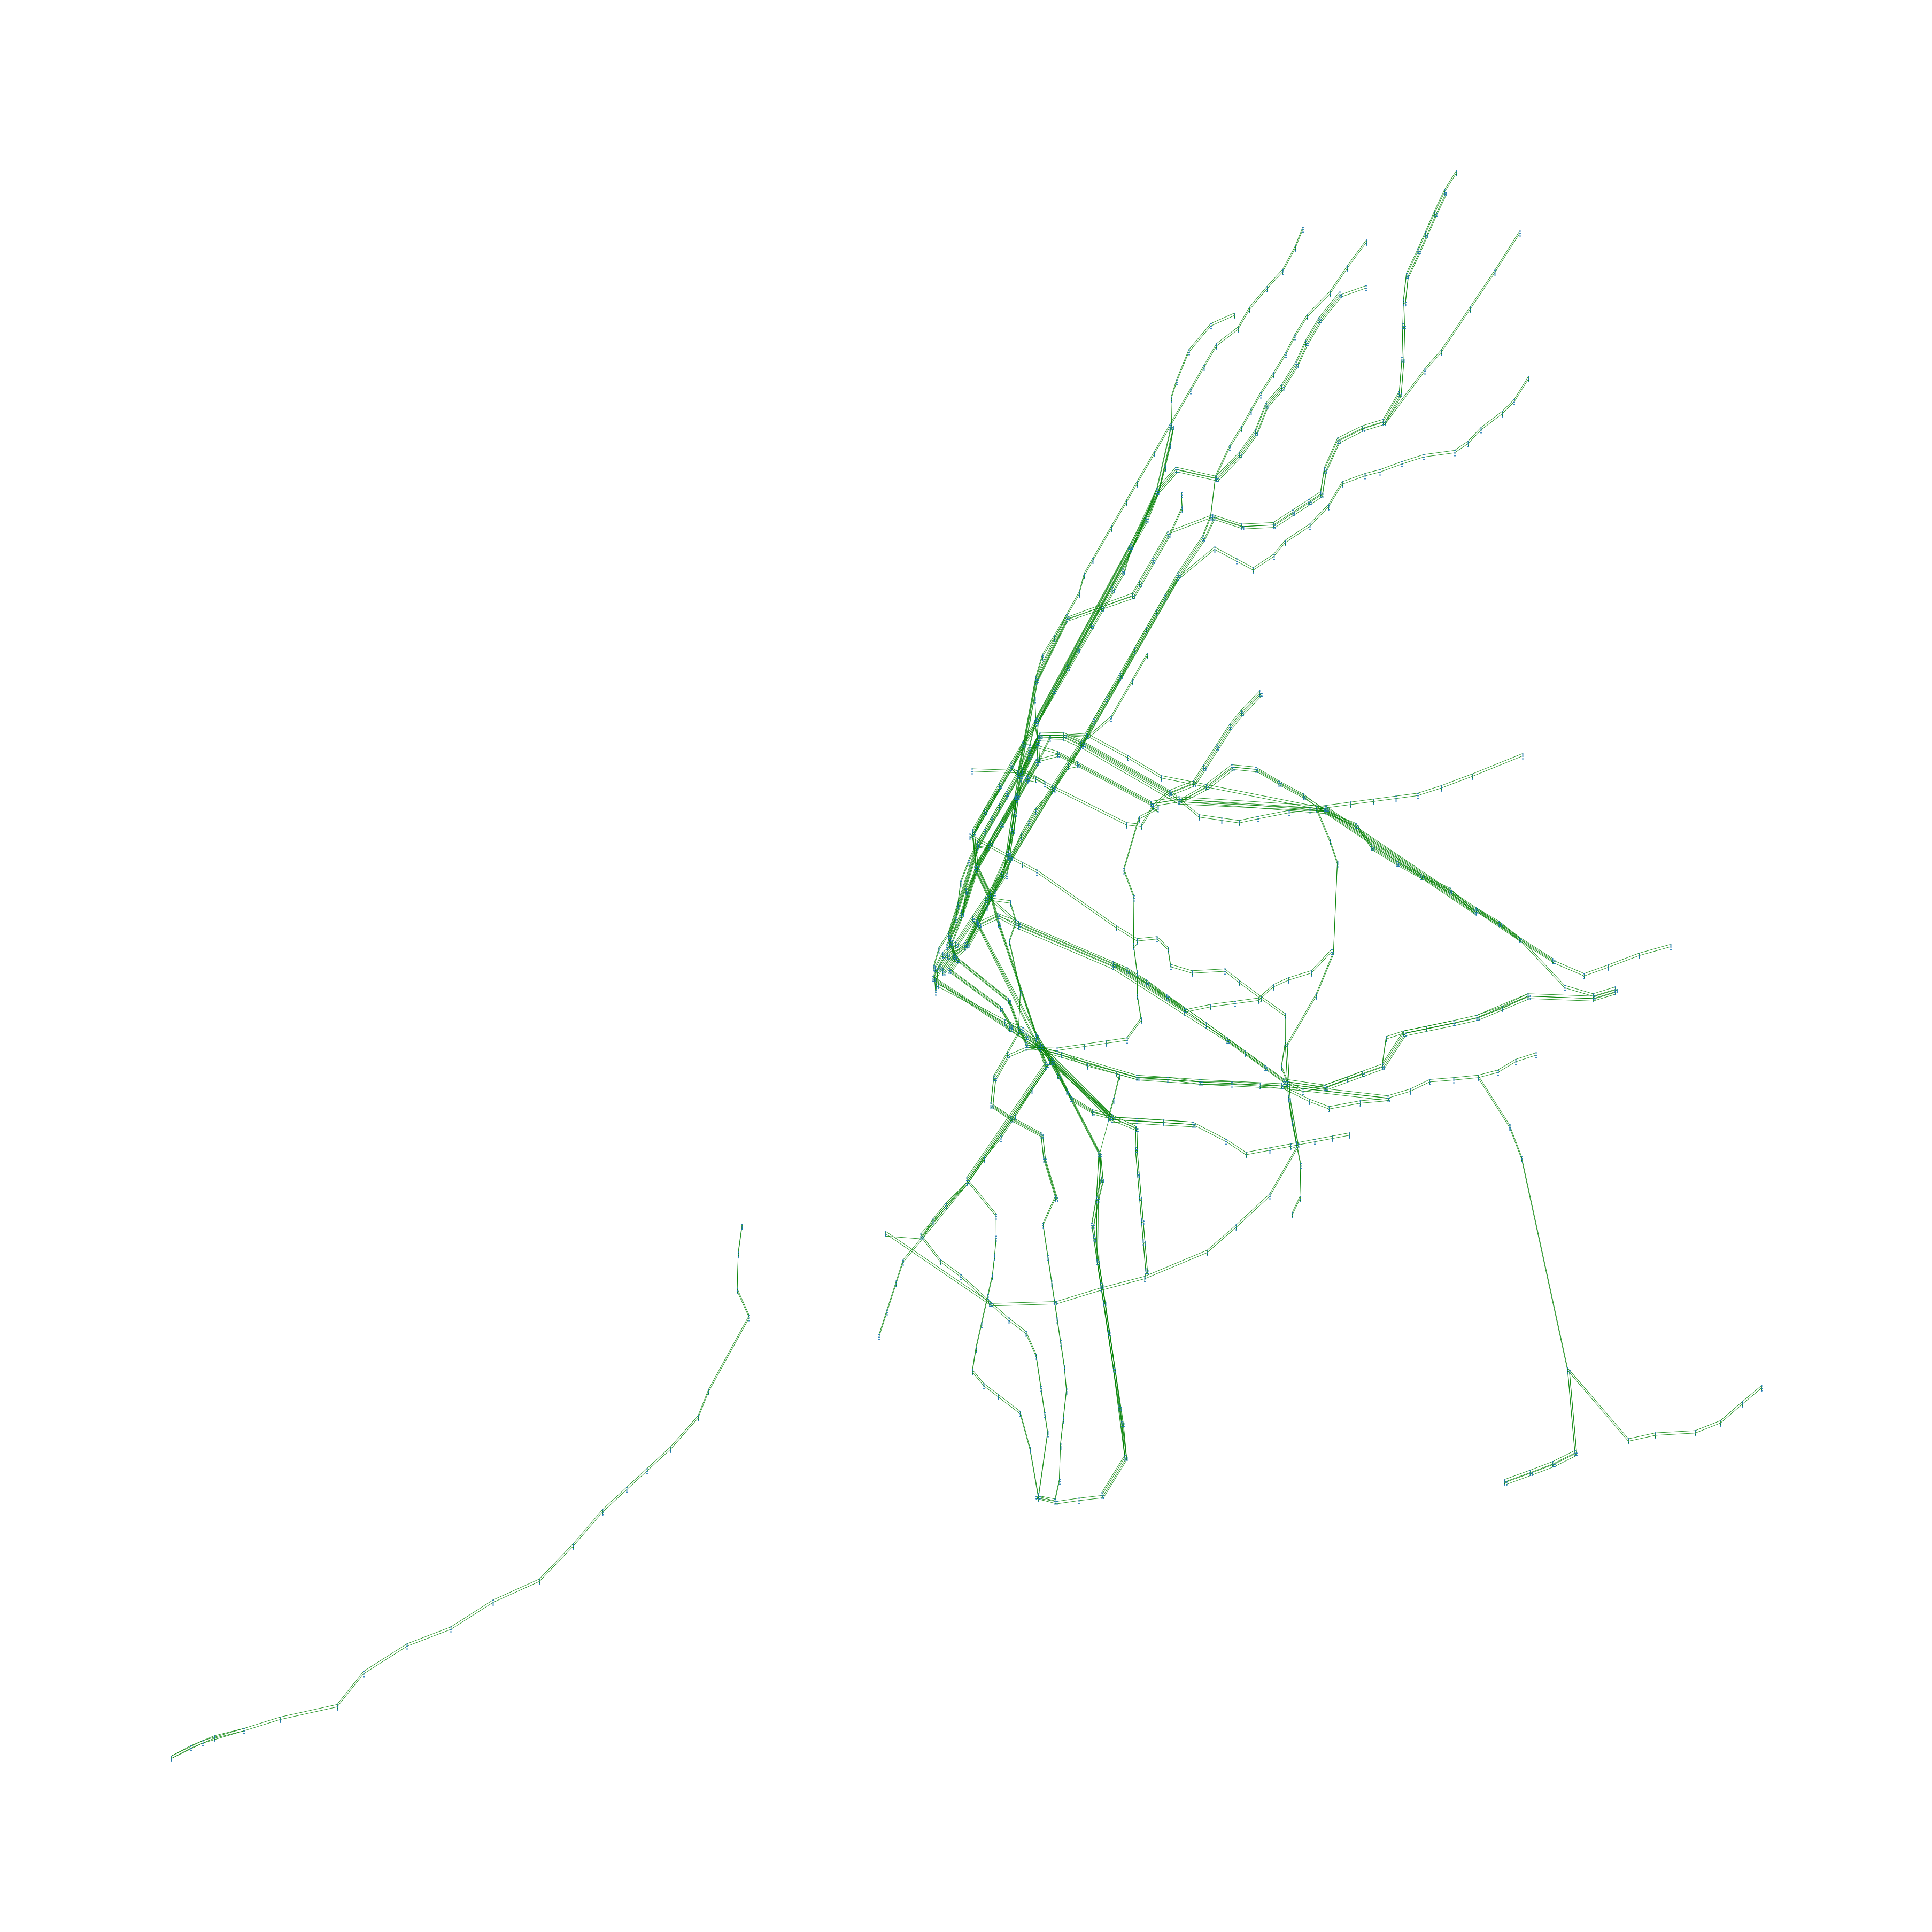

In [26]:
#visualize the subway newtork
plt.figure(figsize = (50,50))
nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=3,width=0.8,edge_color='green')

In [27]:
nx.number_connected_components(uuNYCSubway)

2

In [29]:
for c in nx.connected_components(uuNYCSubway):
    if len(c) < 1000:
        print(c)
    

{'S19-SIR-N', 'S22-SIR-N', 'S21-SIR-S', 'S16', 'S12-SIR-S', 'S13-SIR-S', 'S17-SIR-S', 'S16-SIR-S', 'S26', 'S31-SIR-N', 'S10-SIR-N', 'S23-SIR-N', 'S10-SIR-S', 'S24', 'S11-SIR-N', 'S21-SIR-N', 'S30-SIR-N', 'S26-SIR-N', 'S25', 'S28-SIR-N', 'S14', 'S13', 'S12', 'S25-SIR-N', 'S13-SIR-N', 'S26-SIR-S', 'S09-SIR-S', 'S28-SIR-S', 'S11-SIR-S', 'S20', 'S09', 'S20-SIR-S', 'S18-SIR-N', 'S27-SIR-N', 'S29', 'S23', 'S25-SIR-S', 'S31-SIR-S', 'S15-SIR-S', 'S19-SIR-S', 'S24-SIR-S', 'S18', 'S21', 'S27', 'S24-SIR-N', 'S29-SIR-N', 'S31', 'S15', 'S23-SIR-S', 'S28', 'S30', 'S17-SIR-N', 'S11', 'S18-SIR-S', 'S22', 'S27-SIR-S', 'S30-SIR-S', 'S20-SIR-N', 'S15-SIR-N', 'S14-SIR-N', 'S17', 'S10', 'S14-SIR-S', 'S09-SIR-N', 'S22-SIR-S', 'S16-SIR-N', 'S12-SIR-N', 'S29-SIR-S', 'S19'}


In [ ]:
#the original dataset had missing edges. I used the following code to identify where the gaps were, but then 

In [28]:
#check that each line is a single component. The S line includes the rockaway shuttle, franklin shuttle, and 42nd st shuttle
for l in nodes.loc[nodes['pf_id'] != 'station','line_'].unique():
    lgr=nx.Graph()
    for i in edges.index:
        if edges.loc[i,'line'] == l:
            lgr.add_edge(edges.origin[i],edges.dest[i])  
    cc = nx.number_connected_components(lgr)
    print(f'{l} line has {cc} components')

1 line has 1 components
2 line has 1 components
3 line has 1 components
5 line has 1 components
4 line has 1 components
6 line has 1 components
7 line has 1 components
S line has 3 components
A line has 1 components
C line has 1 components
B line has 1 components
D line has 1 components
E line has 1 components
F line has 1 components
G line has 1 components
Q line has 1 components
M line has 1 components
IBX line has 1 components
N line has 1 components
J line has 1 components
Z line has 1 components
R line has 1 components
L line has 1 components
W line has 1 components
SIR line has 1 components


In [ ]:
#use this function to check that none of the lines has gaps/missing edges
lgr=nx.Graph()
for i in edges.index:
    if edges.loc[i,'line'] == 'Z':
        lgr.add_edge(edges.origin[i],edges.dest[i])  

for c in nx.connected_components(lgr):
    print(c)

plt.figure(figsize = (30,30))
nx.draw(lgr,pos=nodePos,with_labels=True,arrows=False,node_size=3,width=0.8,edge_color='green')

#### Task 1a. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707)

In [30]:
path1=nx.shortest_path(uuNYCSubway,'A41','707')
path2=nx.shortest_path(uuNYCSubway,'A40','F16')

In [31]:
path1

['A41',
 'A41-F-S',
 'F18-F-S',
 'F16-F-S',
 'F15-F-S',
 'F14-F-S',
 'D21-F-S',
 'D20-F-S',
 'D17-F-S',
 'D16-F-S',
 'D15-F-S',
 'B10-F-S',
 'B08-F-S',
 'B06-F-S',
 'B04-F-S',
 'G14-F-S',
 'G14',
 '710',
 '710-7-S',
 '709-7-S',
 '708-7-S',
 '707-7-S',
 '707']

In [33]:
len(path1)

23

In [34]:
#auxiliary function - visualize path on the map
def visualize_path(path):
    plt.figure(figsize = (10,10))
    nx.draw(uuNYCSubway,pos=nodePos,with_labels=False,arrows=False,node_size=1,width=1,edge_color='green')
    x=[nodePos[v][0] for v in path]
    y=[nodePos[v][1] for v in path]
    plt.plot(x,y,'ro-')
    plt.plot([x[0],x[-1]],[y[0],y[-1]],'bs',markersize=10)

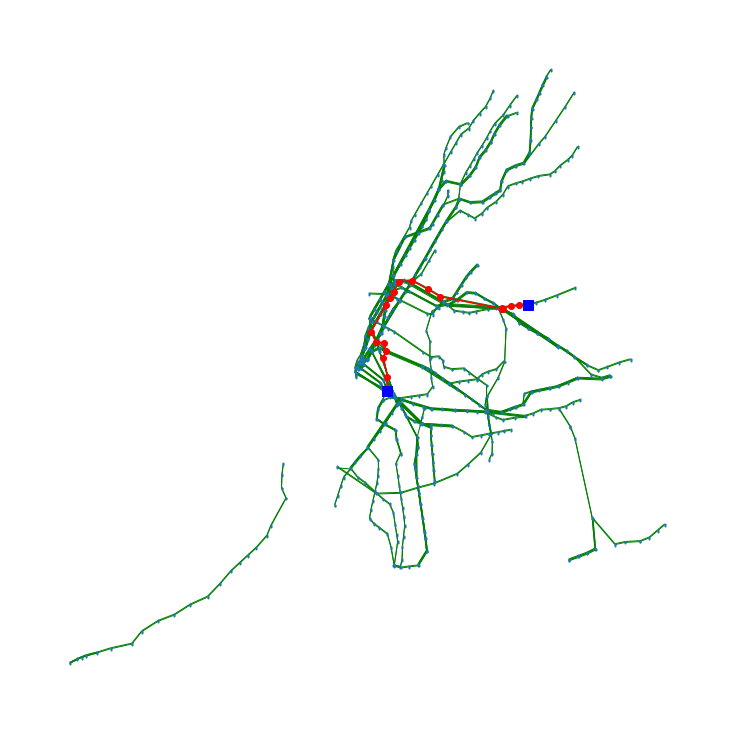

In [35]:
ax1 = visualize_path(path1)
#ax1 = visualize_path(path2)

#### Task 1b. Find shortest path between Jay Str.-Metrotech (A41) and Junction Blvd, Queens (707) in terms of travel distance 

In [ ]:
#auxiliary function: geodesic distance on the Earth surface between two lat-long points
from math import sin, cos, sqrt, atan2, radians
def geodist(lon1,lat1,lon2,lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)  
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [ ]:
#compute and assing lengths the all the edges
nx.set_edge_attributes(uuNYCSubway, 'dist', 0)
for e in uuNYCSubway.edges():
   uuNYCSubway[e[0]][e[1]]['dist']=geodist(nodePos[e[0]][0],nodePos[e[0]][1],nodePos[e[1]][0],nodePos[e[1]][1])

In [ ]:
path1=nx.shortest_path(uuNYCSubway,'A41','707',weight='dist') #shorest path according to dist

In [ ]:
visualize_path(path1)